#  Interpolate LDM results to 0.25 deg

In [1]:
import os
import sys
import time
import h5py

import numpy as np
from glob import glob

from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]    

In [7]:
N_days = 300
N_ens = 10
grid_shape = lon_GFS.shape
LEADs = np.arange(3, 168+3, 3)

In [8]:
base_name = '/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_2023_ini{:02d}_lead{:02d}.hdf'
save_name = 'LDM_025_2023_ini{:02d}_lead{:02d}.hdf'

In [9]:
Y_PRED = np.empty((N_days, N_ens,)+grid_shape); Y_PRED[...] = np.nan

ini = 0
for lead in LEADs:
    with h5py.File(base_name.format(ini, lead), 'r') as h5io:
        y_pred = h5io['MRMS_PRED'][...]

    for day in range(N_days):
        for n in range(N_ens):
            y_pred_ = y_pred[day, n, ...]
    
            if np.sum(np.isnan(y_pred_)) > 0:
                print('missing: day {}; ens {}'.format(day, n))
        
            else:
                hr_to_lr = RegularGridInterpolator((lat_01[:, 0], lon_01[0, :]), y_pred_, 
                                                   bounds_error=False, fill_value=np.nan)
                Y_PRED[day, n, ...] = hr_to_lr((lat_GFS, lon_GFS))
            
    
    save_name_ = save_name.format(ini, lead)
    print('complete: {}'.format(save_name_))
    
    tuple_save = (Y_PRED,)
    label_save = ['Y_PRED',]
    du.save_hdf5(tuple_save, label_save, '/glade/campaign/cisl/aiml/ksha/LDM_results/', save_name_)

complete: LDM_025_2023_ini00_lead03.hdf
Save to /glade/campaign/cisl/aiml/ksha/LDM_results/LDM_025_2023_ini00_lead03.hdf
complete: LDM_025_2023_ini00_lead06.hdf
Save to /glade/campaign/cisl/aiml/ksha/LDM_results/LDM_025_2023_ini00_lead06.hdf


In [10]:
with h5py.File('/glade/campaign/cisl/aiml/ksha/LDM_results/LDM_025_2023_ini00_lead06.hdf', 'r') as h5io:
    Y_PRED_6 = h5io['Y_PRED'][...]

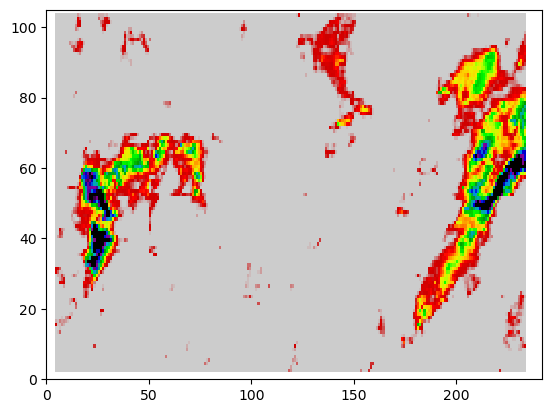

In [18]:
plt.pcolormesh(Y_PRED_6[0, 2, ...], vmin=0, vmax=10, cmap=plt.cm.nipy_spectral_r)